# Practical multimodal use cases with Gemini on Vertex AI


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/devrel-demos/blob/main/ai-ml/gemini-multimodal/vertex_ai_practical_multimodal_use_cases_with_gemini.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Eric Dong](https://github.com/gericdong)|

## Overview

What are the applications of multimodality with Gemini? This session will cover a variety of different multimodal use cases for text, images, and video, and provide some ideas on how to apply multimodality to practical business scenarios.


In this session, you will learn how to use the Python SDK to work with Gemini 1.5's native multimodality and long context window capabilities. You'll explore:

- **Single modality**: Working with text, PDF, image, audio and video inputs individually.
- **Multimodality**: Combining different input types for more complex interactions.
- **Real-world use case**: A practical e-commerce example to demonstrate Gemini's capabilities.


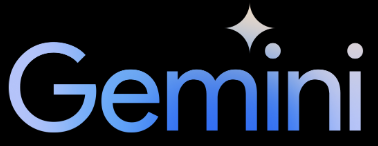

🧡 There are two levels of API platforms for Gemini API:

- **Google AI for Developers**: Experiment, prototype, and deploy small projects.

- **Vertex AI**: Build enterprise-ready projects on Google Cloud ✅

This notebook uses the Vertex AI to explore multimodal use cases with Gemini.

## Getting Started


### Install Vertex AI AI SDK and other required packages


In [ ]:
%%capture

!pip install google-cloud-aiplatform

### Authentication

In [ ]:
from google.colab import auth


# Authenticate Colab user to Google Cloud
auth.authenticate_user()

# Define Google Cloud project information
PROJECT_ID = "<your-project-id>"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [ ]:
import vertexai.generative_models as genai

import PIL.Image
from IPython.display import display, Markdown, Latex, Image, Audio, Video
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Gemini models

The Gemini family of models are the most general and capable AI models we've ever built.

- Ultra — Our largest model for highly complex tasks.
- Pro — Our best model for general performance across a wide range of tasks.
- Flash — Our lightweight model, optimized for speed and efficiency



### Gemini 1.5 Pro and Gemini 1.5 Flash

- `[Gemini 1.5 Pro](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-pro): Optimized for complex reasoning tasks such as code and text generation, text editing, problem solving, data extraction and generation
- [Gemini 1.5 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-flash): Fast and versatile performance across a diverse variety of tasks

If you are not sure which model to use, try `gemini-1.5-flash`. `gemini-1.5-flash` is optimized for multimodal use cases where speed and cost are important.


## Use the Gemini API

These are the examples that demonstrate how to prompt a Gemini 1.5 model using the Gemini API.

#### Gemini 1.5 models

Gemini 1.5 Pro and Gemini 1.5 Flash are multimodal models that support multimodal prompts. Use `GenerativeModel` to load a model.


In [ ]:
GEMINI_FLASH_MODEL_ID = "gemini-1.5-flash" # @param {type:"string"}

model = genai.GenerativeModel(GEMINI_FLASH_MODEL_ID)

#### Generate content

The `generate_content` method can handle a wide variety of use cases, including multi-turn chat and multimodal input, depending on what the underlying model supports.

In [ ]:
response = model.generate_content("What is the meaning of life?")

#### Print model output

In simple cases, the `response.text` accessor is all you need.

In [ ]:
print(response.text)

You can use `Markdown` to display formatted text.

In [ ]:
from IPython.display import Markdown

Markdown(response.text)

#### Streaming

By default, the model returns a response after completing the entire generation process. You can also stream the response as it is being generated, and the model will return chunks of the response as soon as they are generated.

In [ ]:
response = model.generate_content("What is the meaning of life?", stream=True)

In [ ]:
for chunk in response:
  print(chunk.text)
  print("_" * 80)

### Configure model parameters

You learn how to create structured instructions in a prompt and configure the Gemini API with the following configuration options:

- [System instructions](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/system-instructions)
- [Generation parameters](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/inference#parameters)
- [Safety settings](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes)

In this example, you ask the model to be a role of a travel assistant that helps build itineraries based on a location.

In [ ]:
from vertexai.generative_models import (
    GenerationConfig,
    HarmCategory,
    HarmBlockThreshold,
    Part
)

instruction = ("""
You are a seasoned travel blogger and guide with a knack for unearthing hidden gems
and creating unforgettable travel itineraries.

Your task focuses on trip inspiration, detailed planning, and seamless logistics based
on the location the customer is interested in. Document a potential user journey for
finding, curating, and utilizing a travel itinerary designed for this specific location.

Format these itinerary into a table with columns  Day, Location, Experiences,
Things to know and The How. The How column describes in detail how to accomplish the
plan for the experience recommended.
""")

# Load a model with system instruction
model = genai.GenerativeModel(
      model_name=GEMINI_FLASH_MODEL_ID,
      system_instruction=instruction,
)

# Set generation parameters
generation_config = GenerationConfig(
    temperature=0.7,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

# Set safety settings
safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
}


In [ ]:
prompt = """
Location: Beijing
Itinerary:
"""

# Set contents to send to the model
contents = [prompt]

# Prompt the model to generate content
response = model.generate_content(contents,
                                  generation_config=generation_config,
                                  safety_settings=safety_settings)

# Print formatted markdown text
Markdown(response.text)

## Multimodal examples


### 🖼️ Image understanding

This example uses the Gemini API to analyze a product sketch (in this case, a drawing of a Jet Backpack), suggests marketing ideas for it.

First, you download the image and load it with PIL:

In [ ]:
productSketchUrl = "https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg"
!curl -o jetpack.jpg {productSketchUrl}

In [ ]:
img = PIL.Image.open('jetpack.jpg')
display(Image('jetpack.jpg', width=500))

Then you can include the image in our prompt by just passing a list of items to `generate_content`.

In [ ]:
prompt = """This image contains a sketch of a potential product along with some notes.
Given the product sketch, describe the product as thoroughly as possible based on what you
see in the image, making sure to note all of the product features. Return output in json format:
{description: description, features: [feature1, feature2, feature3, etc]}"""

image_file = Part.from_uri(
    "gs://generativeai-downloads/images/jetpack.jpg", "image/jpeg"
)

response = model.generate_content([image_file, prompt])
print(response.text)

#### Generate marketing ideas

Now using the image you can use Gemini API to generate marketing names ideas:

In [ ]:
prompt = """You are a marketing whiz and writer trying to come up with a name for the
product shown in the image. Come up with ten varied, interesting possible names in Chinese. Return the result
in array format, like this: ['name 1', 'name 2', ...]. Pay careful attention
to return a valid array in the format described above, and no other text.
The most important thing is that you stick to the array format."""

response = model.generate_content([image_file, prompt])

names = eval(response.text)
print(names)

### 👏 👏 👏 Try it yourself 👏 👏 👏

**Example images**
- https://storage.googleapis.com/cloud-samples-data/generative-ai/image/mooncake.png
- https://storage.googleapis.com/cloud-samples-data/generative-ai/image/a-man-and-a-dog.png
- https://storage.googleapis.com/cloud-samples-data/generative-ai/image/hurricane-ida.jpeg

**Example prompts**
- Describe the image in detail in Chinese
- What is in the image? Tell me some fun facts about it.
- What is in the image? Write a poem in Shakespearean language in Chinese.

In [ ]:
from urllib.parse import urlparse

def convert_to_gs(url):
    parsed = urlparse(url)
    if parsed.netloc == "storage.googleapis.com":
        path = parsed.path.lstrip("/")  # Remove leading slash from path
        return f"gs://{path}"
    else:
        return url  # Return original URL if not a storage.googleapis.com URL


your_image_url = "" # @param {type:"string"}

!curl -o your_image.jpg {your_image_url}
your_image = PIL.Image.open('your_image.jpg')
display(Image('your_image.jpg', width=500))

your_prompt = "" # @param {type:"string"}


image_file = Part.from_uri(
    convert_to_gs(your_image_url), "image/jpeg"
)

response = model.generate_content([your_prompt, image_file])
Markdown(response.text)

### 📄 PDF and Document Summarization

You can use Gemini to process PDF documents, and analyze content, retain information, and provide answers to queries regarding the documents.

The PDF document example used here is the Gemini 1.5 paper (https://arxiv.org/pdf/2403.05530.pdf).

![image.png](https://storage.googleapis.com/cloud-samples-data/generative-ai/image/gemini1.5-paper-2403.05530.png)

In [ ]:
file_ref = Part.from_uri(uri = "gs://cloud-samples-data/generative-ai/pdf/2403.05530.pdf",
                         mime_type="application/pdf")

model.count_tokens([file_ref, 'Can you summarize this file as a bulleted list?'])

In [ ]:
response = model.generate_content(
    [file_ref, 'Can you summarize this file as a bulleted list?']
)

Markdown(response.text)

### Identify and locate an image in the document

In [ ]:
!curl -o drawing1.png https://storage.googleapis.com/cloud-samples-data/generative-ai/image/drawing1.png
drawing = PIL.Image.open('drawing1.png')
display(Image('drawing1.png', width=200))

In [ ]:
image_file = Part.from_uri(
    "gs://cloud-samples-data/generative-ai/image/drawing1.png", "image/jpeg"
)

response = model.generate_content(
    [file_ref, image_file, 'Find the drawing in the document and explain why the drawing appears there.']
)

Markdown(response.text)

## 🔊 Audio

#### Audio summarization

In [ ]:
audio_file_url = "https://storage.googleapis.com/cloud-samples-data/generative-ai/audio/pixel.mp3"

!curl -o audio.mp3 {audio_file_url}

Audio(audio_file_url)

In [ ]:
prompt = """
  Please provide a short summary and title for the audio.
  Provide chapter titles, be concise and short, no need to provide chapter summaries.
  Provide each of the chapter titles in a numbered list.
  Do not make up any information that is not part of the audio and do not be verbose.
"""

audio_file = Part.from_uri("gs://cloud-samples-data/generative-ai/audio/pixel.mp3",
                           mime_type="audio/mpeg")

response = model.generate_content(
    [audio_file, prompt]
)

Markdown(response.text)

### 👏 👏 👏 Try it yourself 👏 👏 👏

**Example audio**
- https://storage.googleapis.com/cloud-samples-data/generative-ai/audio/audio_summary_clean_energy.mp3

**Example prompts**
- Transcribe this audio
- Transcribe this audio and translate it to Chinese

In [ ]:
your_audio_url = "" # @param {type:"string"}

!curl -o test.mp3 {your_audio_url}
Audio(your_audio_url)

your_prompt = "" # @param {type:"string"}

audio_file = Part.from_uri(convert_to_gs(your_audio_url),
                           mime_type="audio/mpeg")

response = model.generate_content(
    [audio_file, your_prompt]
)

Markdown(response.text)

## 🎬 Video

Native multimodal and long context capabilities on video interleaving with audio inputs.

In [ ]:
video_file_url = "https://storage.googleapis.com/cloud-samples-data/generative-ai/video/pixel8.mp4"

!curl -o video.mp4 {video_file_url}
Video(video_file_url, width=450)

In [ ]:
prompt = """
Look through each frame in the video carefully and answer the question.
Only base your answers strictly on what information is available in the video attached.
Do not make up any information that is not part of the video and do not be too verbose.

Questions:
- When does a red lantern first appear and what is written in the lantern? Provide a timestamp.
- What language is the person speaking and what does the person say at that time?
"""

video_file = Part.from_uri(uri = "gs://cloud-samples-data/generative-ai/video/pixel8.mp4",
                      mime_type="video/mp4")

response = model.generate_content([video_file, prompt])

print(response.text)

## Use Case: retail / e-commerce

The customer shows you their living room:

|Customer photo |
|:-----:|
|<img src="https://storage.googleapis.com/cloud-samples-data/generative-ai/image/living-room.png" width="50%">  |



Below are four wall art options that the customer is trying to decide between:

|Art 1| Art 2 | Art 3 | Art 4 |
|:-----:|:----:|:-----:|:----:|
| <img src="https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-1.png" width="60%">|<img src="https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-2.png" width="100%">|<img src="https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-3.png" width="60%">|<img src="https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-4.png" width="60%">|


How can you use Gemini 1.5, a multimodal model, to help the customer choose the best option?

### Generating open recommendations

Using the same image, you can ask the model to recommend a piece of furniture that would make sense in the space.

Note that the model can choose any furniture in this case, and can do so only from its built-in knowledge.

In [ ]:
# urls for room images
room_image_url = "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/living-room.png"

# load room images as Image Objects
def load_image_from_url(url):
  file_name = url.split('/')[-1]
  !curl -o {file_name} {url}
  return Part.from_uri(convert_to_gs(url), "image/jpeg")

room_image = load_image_from_url(room_image_url)
display(Image(room_image_url.split('/')[-1], width=300))

prompt = "Describe this room"
response = model.generate_content([prompt, room_image])
Markdown(response.text)

In [ ]:
prompt1 = "Recommend a new piece of furniture for this room"
prompt2 = "Explain the reason in detail"
contents = [prompt1, room_image, prompt2]

response = model.generate_content(contents)
Markdown(response.text)

### Generating recommendations based on provided images

Instead of keeping the recommendation open, you can also provide a list of items for the model to choose from. Here, you will download a few art images that the Gemini model can recommend. This is particularly useful for retail companies who want to provide product recommendations to users based on their current setup.

In [ ]:
# Download and display sample artwork
art_image_urls = [
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-1.png",
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-2.png",
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-3.png",
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/room-art-4.png",
]


# Load wall art images as Image Objects
art_images = [load_image_from_url(url) for url in art_image_urls]

In [ ]:
# To recommend an item from a selection, you will need to label the item number within the prompt.
# That way you are providing the model with a way to reference each image as you pose a question.
# Labeling images within your prompt also helps reduce hallucinations and produce better results.
prompt = """
  You are an interior designer.
  For each piece of wall art, explain whether it would be appropriate for the style of the room.
  Rank each piece according to how well it would be compatible in the room.
"""
contents = [
    "Consider the following art pieces:",
    "art 1:",
    art_images[0],
    "art 2:",
    art_images[1],
    "art 3:",
    art_images[2],
    "art 4:",
    art_images[3],
    "room:",
    room_image,
    prompt,
]

display(Image(room_image_url.split('/')[-1], width=300))
print("\n------Art1:-------")
display(Image(art_image_urls[0].split('/')[-1], width=300))
print("\n------Art2:-------")
display(Image(art_image_urls[1].split('/')[-1], width=300))
print("\n------Art3:-------")
display(Image(art_image_urls[2].split('/')[-1], width=300))
print("\n------Art4:-------")
display(Image(art_image_urls[3].split('/')[-1], width=300))

response = model.generate_content(contents)
Markdown(response.text)

In [ ]:
print("\nArt2: most appropriate!")
display(Image(art_image_urls[1].split('/')[-1], width=300))

## Conclusions

In this session, you've learned how to use Gemini 1.5's native multimodality and long context window capabilities to explore:

- **Single modality**: Working with text, PDF, image, audio and video inputs individually.
- **Multimodality**: Combining different input types for more complex interactions.
- **Real-world use case**: A practical e-commerce example to demonstrate Gemini's capabilities.

Next, you can continue to explore more examples on:

- [Gemini API Cookbook](https://github.com/google-gemini/cookbook/)
- [Vertex AI Generative AI notebook samples](https://github.com/GoogleCloudPlatform/generative-ai)